In [1]:
import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell
def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path
    
    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path
        
class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path
    
    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)
        
        print ("importing Jupyter notebook from %s" % path)
                                       
        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)
        
        
        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod
        
        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__
        
        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod
class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}
    
    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return
        
        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)
        
        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]

sys.meta_path.append(NotebookFinder())

### Inception Block

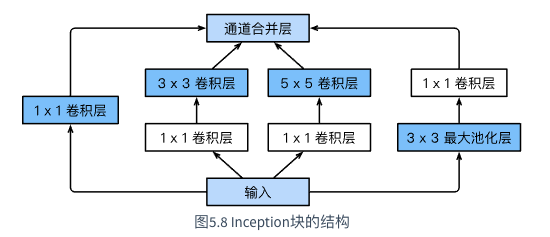

In [2]:
import time
import torch
from torch import nn,optim
import torch.nn.functional as F

In [3]:
import sys
sys.path.append("..")

In [4]:
from chapter_3 import d2l

importing Jupyter notebook from ../chapter_3/d2l.ipynb


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
class Inception(nn.Module):
    def __init__(self,in_c,c1,c2,c3,c4):
        super(Inception,self).__init__()
        
        #最左侧 1x1卷积
        self.p1_1 = nn.Conv2d(in_c,c1,kernel_size=1)
        #第二列 1x1卷积层接3x3卷积层
        self.p2_1 = nn.Conv2d(in_c,c2[0],kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0],c2[1],kernel_size=2,padding=1)
        #第三列 1x1卷积层接5x5卷积层
        self.p3_1 = nn.Conv2d(in_c,c3[0],kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0],c3[1],kernel_size=5,padding=2)#padding = 2?
        #最右侧 3x3接1x1
        self.p4_1 = nn.MaxPool2d(kernel_size=3,stride=1,padding=1)
        self.p4_2 = nn.Conv2d(in_c,c4,kernel_size=1)
        
    def forward(self,x):
        p1= F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        
        return torch.cat(torch.cat(p1,p2,p3,p4),dim=1)#nchw

### GoogleNet

#### 第一个模块

In [7]:
b1 = nn.Sequential(nn.Conv2d(1,64,kernel_size=7,stride=2,padding=3),nn.ReLU(),nn.MaxPool2d(kernel_size=3,stride=2,padding=1))

#### 第二个模块